# Analyze SAXS Data on Nanoparticles in Water

The following code analyzes SAXS data on 50 +/- 3 nm SiO2 nanoparticles dispersed in water obtained during beamtime from 3/27/19-4/1/19 at the Argonne Photon Source (APS).

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

from scipy.signal import medfilt2d

import saxs

from importlib import reload
reload(saxs)

# PARAMETERS
data_folder_path = '..\\..\\EXPERIMENTS\\APS\\APS_NP_MF_DEVICE\\SAXS\\flow\\'
filename_structure = 'flow_hs104_*.tif'
r_lim = (10,500)
phi_lim = (-np.pi/2, 0)
scan_list = [181]
bkgd_scan = 175

## Load Data

We first load the images of SAXS patterns from the data.

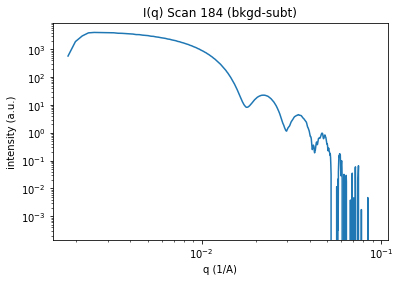

In [29]:
# Get file path
filepath_structure = os.path.join(data_folder_path,filename_structure)
file_list = glob.glob(filepath_structure)

# Average background intensities
bkgd_file_list = [f for f in file_list if str(bkgd_scan) in f]
bkgd_mean, q = saxs.average_intensity_scan(bkgd_file_list, 'phi', phi_lim=phi_lim, r_lim=r_lim)

# Organize data structures for intensity for each scan of data
file_list_by_scan = [[f for f in file_list if str(scan) in f] for scan in scan_list]
scan_intensity_dict = {}

# Average results from each scan and subtract background
for i in range(len(file_list_by_scan)):
    scan_file_list = file_list_by_scan[i]
    scan_mean, q = saxs.average_intensity_scan(scan_file_list, 'phi', phi_lim=phi_lim, r_lim=r_lim)    
    intensity_subt = scan_mean - bkgd_mean
    scan_intensity_dict[scan] = intensity_subt
    # Plot background-subtracted data
    plt.figure()
    plt.loglog(q, intensity_subt)
    plt.xlabel('q (1/A)')
    plt.ylabel('intensity (a.u.)')
    plt.title('I(q) Scan {scan} (bkgd-subt)'.format(scan=scan))